# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [76]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [77]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [78]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [79]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [80]:
# define a function to load json file to a dataframe
def load_json_dataframe(file_path):
    """
    Load JSON data from file and convert to DataFrame
    
    Parameters:
    file_path (str): Path to the JSON file
    
    Returns:
    pd.DataFrame: DataFrame containing the JSON data
    """
    with open(file_path, 'r') as file:
        data = json.load(file)
    df = pd.DataFrame(data)
    return df

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [81]:
# read the json file by giving the file path and create a dataframe
df = load_json_dataframe('ingredient_and_quantity.json')

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [82]:
# display first five rows of the dataframe - df
print("First 5 rows of the dataframe:")
print(df.head())

First 5 rows of the dataframe:
                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin

In [83]:
# print the dimensions of dataframe - df
print(f"\nDimensions of dataframe: {df.shape}")


Dimensions of dataframe: (285, 2)


In [84]:
# print the information of the dataframe
print("\nDataframe info:")
print(df.info())


Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB
None


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [85]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df['input_tokens'] = df['input'].apply(lambda x: x.split())

# Tokenize POS
df['pos_tokens'] = df['pos'].apply(lambda x: x.split())

In [86]:
# display first five rows of the dataframe - df
print("First 5 rows after tokenization:")
print(df.head())

First 5 rows after tokenization:
                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                             

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [87]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [88]:
# check for the equality of input_length and pos_length in the dataframe
unequal_rows = df[df['input_length'] != df['pos_length']]
print(f"Number of rows with unequal input and pos lengths: {len(unequal_rows)}")
if len(unequal_rows) > 0:
    print("Unequal rows indices:", unequal_rows.index.tolist())

Number of rows with unequal input and pos lengths: 5
Unequal rows indices: [17, 27, 79, 164, 207]


##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [89]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(dataframe):
    """
    Find all unique POS labels in the recipe data
    
    Parameters:
    dataframe (pd.DataFrame): DataFrame containing pos_tokens column
    
    Returns:
    set: Set of unique labels
    """
    all_labels = []
    for pos_list in dataframe['pos_tokens']:
        all_labels.extend(pos_list)
    unique_labels_set = set(all_labels)
    print(f"Unique labels found: {unique_labels_set}")
    print(f"Total number of unique labels: {len(unique_labels_set)}")
    return unique_labels_set
unique_labels_in_data = unique_labels(df)

Unique labels found: {'quantity', 'ingredient', 'unit'}
Total number of unique labels: 3


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

In [90]:
print("\nInsights from data validation:")
print(f"- Total recipes: {len(df)}")
print(f"- Rows with length mismatch: {len(unequal_rows)}")
print(f"- Unique POS labels: {len(unique_labels_in_data)}")
if len(unequal_rows) > 0:
    print(f"Problematic rows that need cleaning: {unequal_rows.index.tolist()}")


Insights from data validation:
- Total recipes: 285
- Rows with length mismatch: 5
- Unique POS labels: 3
Problematic rows that need cleaning: [17, 27, 79, 164, 207]


<font color = red>[ Insights from data validation: ]
- Total recipes: 285
- Rows with length mismatch: 5
- Unique POS labels: 3
- Problematic rows that need cleaning: [17, 27, 79, 164, 207]</font> <br>


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [91]:
# drop the irrelevant recipe data
if len(unequal_rows) > 0:
    df = df.drop(unequal_rows.index)
    df = df.reset_index(drop=True)
    print(f"Dropped {len(unequal_rows)} rows with invalid data")
    print(f"New dataframe shape: {df.shape}")

Dropped 5 rows with invalid data
New dataframe shape: (280, 6)


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [92]:
# update the input and pos length in input_length and pos_length
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)


##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [93]:
# validate the input length and pos length as input_length and pos_length
final_check = df[df['input_length'] != df['pos_length']]
print(f"Final validation - rows with unequal lengths: {len(final_check)}")

Final validation - rows with unequal lengths: 0


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [94]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

Training set size: 196
Validation set size: 84


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [95]:
# print the first five rows of train_df
print("\nFirst 5 rows of training data:")
print(train_df.head())


First 5 rows of training data:
                                                                                                                                                                                                                                                           input                                                                                                                                                                                                                                                                                                                                                                                                                                       pos                                                                                                                                                                                                                                                                                           inp

In [96]:
# print the first five rows of the val_df
print("\nFirst 5 rows of validation data:")
print(val_df.head())


First 5 rows of validation data:
                                                                                                                                                                                                                                                                                                                                                                         input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                               

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [97]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df['input_tokens'].tolist()
X_val = val_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

In [98]:
# validate the shape of training and validation samples
print(f"X_train length: {len(X_train)}")
print(f"X_val length: {len(X_val)}")
print(f"y_train length: {len(y_train)}")
print(f"y_val length: {len(y_val)}")

X_train length: 196
X_val length: 84
y_train length: 196
y_val length: 84


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [99]:
# Display the number of unique labels present in y_train
all_train_labels = []
for label_list in y_train:
    all_train_labels.extend(label_list)

unique_train_labels = set(all_train_labels)
print(f"Number of unique labels in y_train: {len(unique_train_labels)}")
print(f"Unique labels: {unique_train_labels}")

Number of unique labels in y_train: 3
Unique labels: {'quantity', 'unit', 'ingredient'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [100]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    """
    Flatten a nested list structure
    
    Parameters:
    nested_list (list): List of lists to flatten
    
    Returns:
    list: Flattened list
    """
    flattened = []
    for sublist in nested_list:
        flattened.extend(sublist)
    return flattened

In [101]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [102]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens(dataframe, dataset_name):
    """
    Extract and validate tokens from dataframe
    
    Parameters:
    dataframe (pd.DataFrame): Input dataframe
    dataset_name (str): Name of the dataset (Training/Validation)
    
    Returns:
    tuple: (tokens, pos_tags)
    """
    input_tokens_list = dataframe['input_tokens'].tolist()
    pos_tokens_list = dataframe['pos_tokens'].tolist()
    tokens = flatten_list(input_tokens_list)
    pos_tags = flatten_list(pos_tokens_list)
    
    print(f"{dataset_name} Dataset:")
    print(f"Total tokens: {len(tokens)}")
    print(f"Total POS tags: {len(pos_tags)}")
    print(f"Length match: {len(tokens) == len(pos_tags)}")
    
    print(f"\nFirst 10 tokens: {tokens[:10]}")
    print(f"First 10 POS tags: {pos_tags[:10]}")
    
    return tokens, pos_tags

In [103]:
# extract the tokens and its pos tags
tokens, pos_tags = extract_and_validate_tokens(train_df, dataset_name)

Training Dataset:
Total tokens: 7114
Total POS tags: 7114
Length match: True

First 10 tokens: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']
First 10 POS tags: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [104]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays
def categorize_tokens(tokens, pos_tags):
    """
    Categorize tokens into ingredients, units and quantities
    
    Parameters:
    tokens (list): List of tokens
    pos_tags (list): List of corresponding POS tags
    
    Returns:
    tuple: (ingredients, units, quantities)
    """
    ingredients = []
    units = []
    quantities = []
    
    for token, pos in zip(tokens, pos_tags):
        if pos == 'ingredient':
            ingredients.append(token)
        elif pos == 'unit':
            units.append(token)
        elif pos == 'quantity':
            quantities.append(token)
    
    print(f"Ingredients found: {len(ingredients)}")
    print(f"Units found: {len(units)}")
    print(f"Quantities found: {len(quantities)}")
    
    return ingredients, units, quantities


In [105]:
#  call the function to categorise the labels into respective list
ingredients, units, quantities = categorize_tokens(tokens, pos_tags)


Ingredients found: 5323
Units found: 811
Quantities found: 980


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [106]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
def get_top_frequent_items(item_list, pos_label, dataset_name, top_n=10):
    """
    Get top N most frequent items
    
    Parameters:
    item_list (list): List of items
    pos_label (str): Label type (ingredient/unit)
    dataset_name (str): Dataset name
    top_n (int): Number of top items to return
    
    Returns:
    list: List of tuples (item, count)
    """
    counter = Counter(item_list)
    top_items = counter.most_common(top_n)
    
    print(f"\nTop {top_n} most frequent {pos_label}s in {dataset_name} dataset:")
    for i, (item, count) in enumerate(top_items, 1):
        print(f"{i}. {item}: {count}")
    
    return top_items

In [107]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients = get_top_frequent_items(ingredients, 'ingredient', dataset_name)


Top 10 most frequent ingredients in Training dataset:
1. powder: 129
2. Salt: 102
3. seeds: 89
4. Green: 85
5. chopped: 84
6. Oil: 83
7. Red: 81
8. Chilli: 77
9. Coriander: 71
10. Sunflower: 65


In [108]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(units, 'unit', dataset_name)


Top 10 most frequent units in Training dataset:
1. teaspoon: 162
2. cup: 136
3. tablespoon: 99
4. grams: 63
5. tablespoons: 61
6. inch: 52
7. cups: 50
8. sprig: 41
9. cloves: 39
10. teaspoons: 39


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [109]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(top_items, label, dataset_name):
    """
    Plot bar graph for top frequent items
    
    Parameters:
    top_items (list): List of tuples (item, count)
    label (str): Label type (ingredient/unit)
    dataset_name (str): Dataset name
    """
    if not top_items:
        print(f"No {label} data to plot")
        return
    
    items, counts = zip(*top_items)
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(items)), counts)
    plt.title(f'Top {len(items)} Most Frequent {label.title()}s in {dataset_name} Dataset')
    plt.xlabel(f'{label.title()}s')
    plt.ylabel('Frequency')
    plt.xticks(range(len(items)), items, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



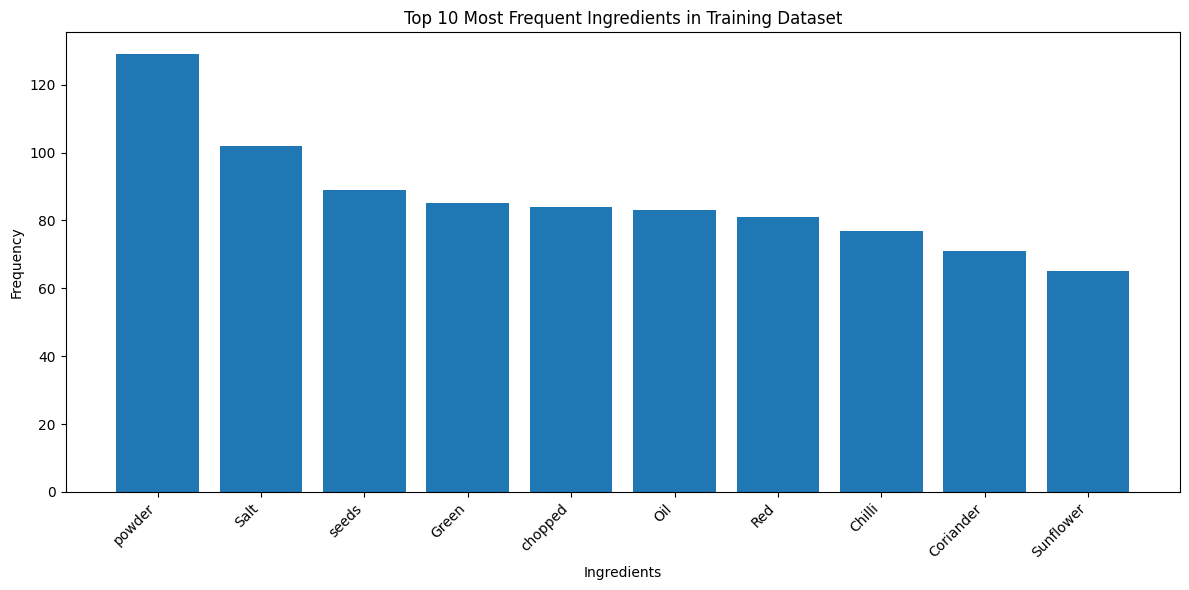

In [110]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients, 'ingredient', dataset_name)

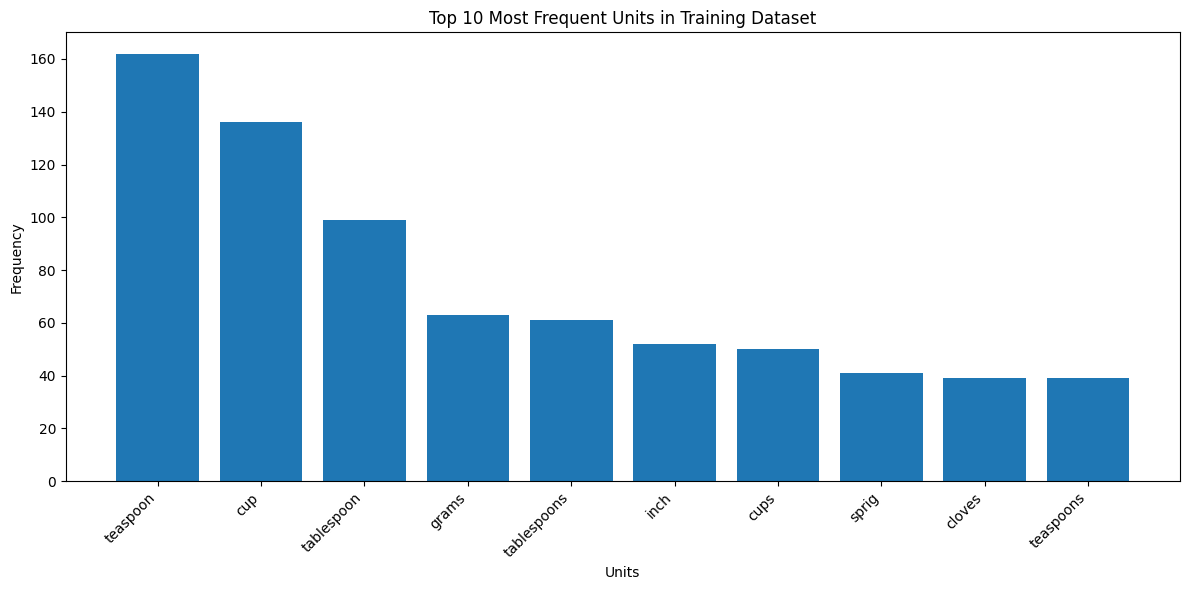


EDA Insights for Training Dataset:
1. Most common ingredients: ['powder', 'Salt', 'seeds', 'Green', 'chopped']
2. Most common units: ['teaspoon', 'cup', 'tablespoon', 'grams', 'tablespoons']
3. Total unique ingredients: 836
4. Total unique units: 45
5. Ingredient to unit ratio: 6.56


In [111]:
# plot the top frequent units in training data
plot_top_items(top_units, 'unit', dataset_name)
print("\nEDA Insights for Training Dataset:")
print("="*50)
print(f"1. Most common ingredients: {[item[0] for item in top_ingredients[:5]]}")
print(f"2. Most common units: {[item[0] for item in top_units[:5]]}")
print(f"3. Total unique ingredients: {len(set(ingredients))}")
print(f"4. Total unique units: {len(set(units))}")
print(f"5. Ingredient to unit ratio: {len(ingredients)/len(units):.2f}")


## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [112]:
# initialise the dataset_name
dataset_name_val = 'Validation'

In [113]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe
val_tokens, val_pos_tags = extract_and_validate_tokens(val_df, dataset_name_val)
val_ingredients, val_units, val_quantities = categorize_tokens(val_tokens, val_pos_tags)
val_top_ingredients = get_top_frequent_items(val_ingredients, 'ingredient', dataset_name_val)
val_top_units = get_top_frequent_items(val_units, 'unit', dataset_name_val)

Validation Dataset:
Total tokens: 2876
Total POS tags: 2876
Length match: True

First 10 tokens: ['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee']
First 10 POS tags: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient']
Ingredients found: 2107
Units found: 358
Quantities found: 411

Top 10 most frequent ingredients in Validation dataset:
1. powder: 54
2. Salt: 47
3. Oil: 39
4. Red: 39
5. seeds: 36
6. Chilli: 36
7. chopped: 31
8. Green: 30
9. Leaves: 29
10. Coriander: 27

Top 10 most frequent units in Validation dataset:
1. teaspoon: 59
2. cup: 57
3. tablespoon: 32
4. tablespoons: 32
5. cups: 24
6. sprig: 21
7. inch: 20
8. grams: 19
9. teaspoons: 18
10. cloves: 16


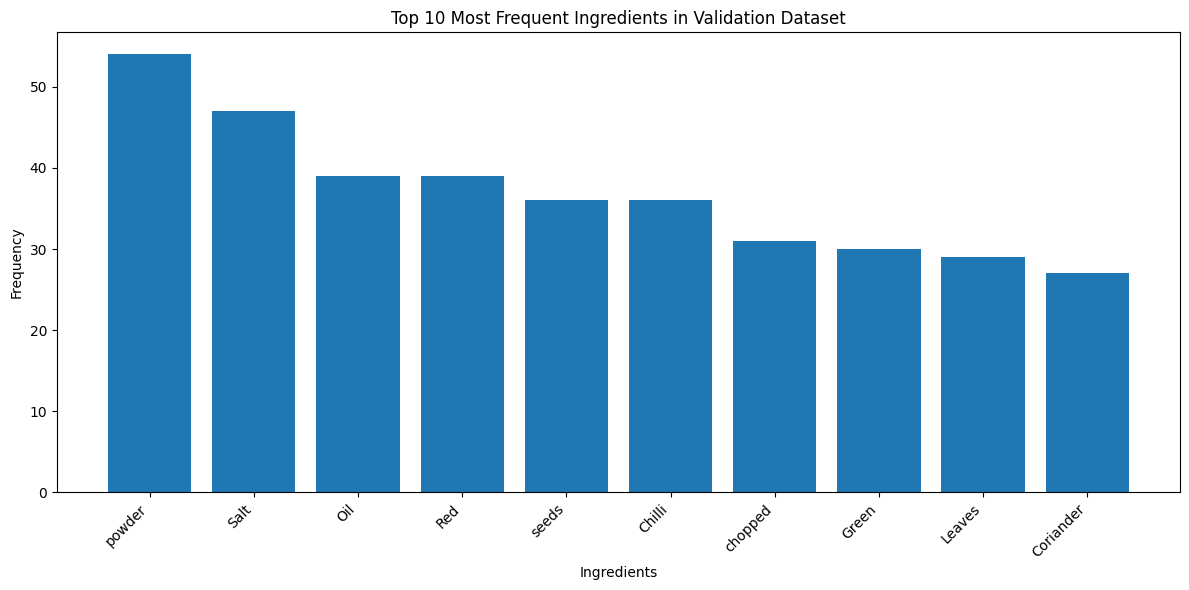

In [114]:
# plot the top frequent ingredients in validation data
plot_top_items(val_top_ingredients, 'ingredient', dataset_name_val)

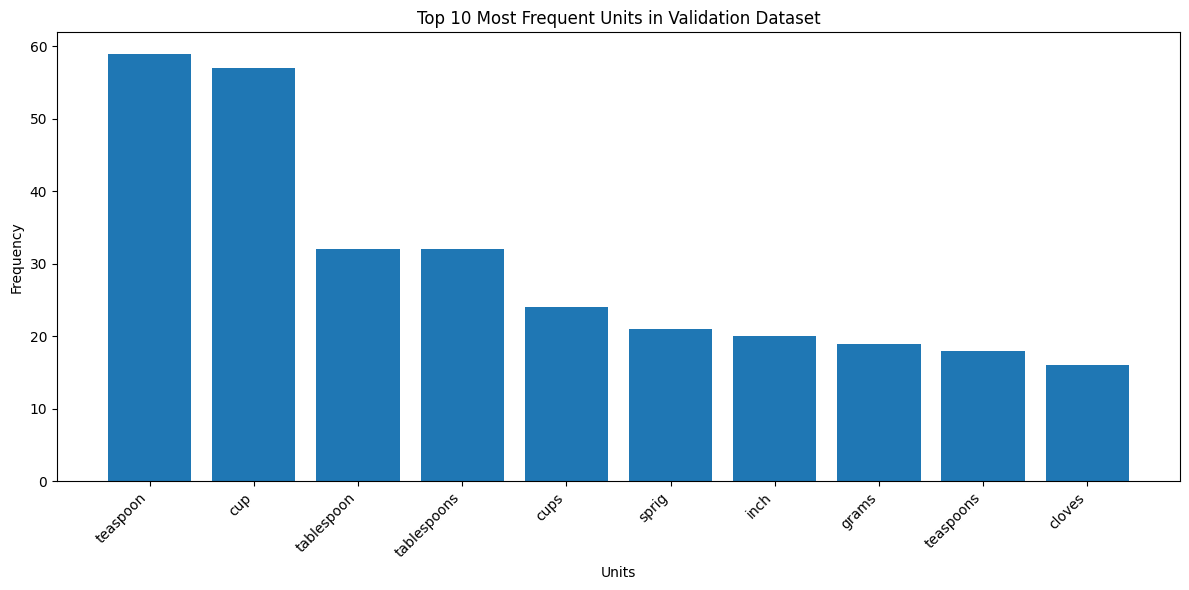

In [115]:
# plot the top frequent units in training data
plot_top_items(val_top_units, 'unit', dataset_name_val)

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [116]:
# define unit and quantity keywords along with quantity pattern
unit_keywords = {
    'cup', 'cups', 'tablespoon', 'tablespoons', 'teaspoon', 'teaspoons',
    'tbsp', 'tsp', 'gram', 'grams', 'kg', 'ml', 'liter', 'liters',
    'pound', 'pounds', 'ounce', 'ounces', 'inch', 'inches', 'unit',
    'clove', 'cloves', 'sprig', 'sprigs', 'pinch', 'handful', 'bunch'
}

quantity_keywords = {
    'half', 'quarter', 'few', 'little', 'some', 'more', 'extra',
    'optional', 'needed', 'required', 'taste'
}
quantity_pattern = re.compile(r'^\d+([\/\-]\d+)*(\.\d+)?$|^\d+$')

In [117]:
!pip install spacy

In [118]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     ---- ----------------------------------- 1.3/12.8 MB 2.8 MB/s eta 0:00:05
     ---- ----------------------------------- 1.6/12.8 MB 2.3 MB/s eta 0:00:05
     ------ --------------------------------- 2.1/12.8 MB 2.9 MB/s eta 0:00:04
     --------- ------------------------------ 3.1/12.8 MB 2.9 MB/s eta 0:00:04
     ------------ --------------------------- 3.9/12.8 MB 3.0 MB/s eta 0:00:03
     ------------- -------------------------- 4.5/12.8 MB 3.2 MB/s eta 0:00:03
     ------------- -------------------------- 4.5/12.8 MB 3.2 MB/s eta 0:00:03
     --------------- ------------------------ 5.0/12.8 MB 2.6 MB/s eta 0:00:04
     --------------- ------------------------ 5.0/12.8 MB 2.6 MB/s eta 0:00:04
     ------------------ --------------------- 5.8/12.8 MB 2.5 MB/s eta 0:00:03
     ------------------- -------------------- 6.3/12.8 MB 2.5 MB/s

In [119]:
# load spaCy model
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    print("Please install spaCy English model: python -m spacy download en_core_web_sm")
    # Create a simple tokenizer as fallback
    class SimpleNLP:
        def __call__(self, text):
            return SimpleDoc(text.split())
    
    class SimpleDoc:
        def __init__(self, tokens):
            self.tokens = [SimpleToken(token) for token in tokens]
        def __iter__(self):
            return iter(self.tokens)
    
    class SimpleToken:
        def __init__(self, text):
            self.text = text
            self.lemma_ = text.lower()
            self.pos_ = 'NOUN'  # Default POS
            self.tag_ = 'NN'
            self.dep_ = 'nsubj'
            self.shape_ = 'Xxx' if text[0].isupper() else 'xxx'
            self.is_stop = text.lower() in ['the', 'a', 'an', 'and', 'or', 'but']
            self.is_digit = text.isdigit()
            self.is_title = text.istitle()
            self.is_upper = text.isupper()
            self.is_punct = not text.isalnum()
    
    nlp = SimpleNLP()

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [120]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions
def word2features(sent, i):
    """
    Extract features for token at position i in sentence sent
    
    Parameters:
    sent (list): List of tokens in the sentence
    i (int): Index of current token
    
    Returns:
    dict: Dictionary of features
    """
    # Process the entire sentence with spaCy
    doc = nlp(' '.join(sent))
    tokens = list(doc)
    
    if i >= len(tokens):
        i = len(tokens) - 1
    
    token = tokens[i]
    word = sent[i] if i < len(sent) else ''
    
    # Initialize features dictionary
    features = {}
    # --- Core Features ---
    features['bias'] = 1.0
    features['token'] = word.lower()
    features['lemma'] = token.lemma_.lower() if hasattr(token, 'lemma_') else word.lower()
    features['pos_tag'] = token.pos_ if hasattr(token, 'pos_') else 'NOUN'
    features['tag'] = token.tag_ if hasattr(token, 'tag_') else 'NN'
    features['dep'] = token.dep_ if hasattr(token, 'dep_') else 'nsubj'
    features['shape'] = token.shape_ if hasattr(token, 'shape_') else ('Xxx' if word and word[0].isupper() else 'xxx')
    features['is_stop'] = token.is_stop if hasattr(token, 'is_stop') else word.lower() in ['the', 'a', 'an']
    features['is_digit'] = word.isdigit()
    features['has_digit'] = any(c.isdigit() for c in word)
    features['has_alpha'] = any(c.isalpha() for c in word)
    features['hyphenated'] = '-' in word
    features['slash_present'] = '/' in word
    features['is_title'] = word.istitle()
    features['is_upper'] = word.isupper()
    features['is_punct'] = not word.isalnum() if word else False
    # --- Improved Quantity & Unit Detection ---
    features['is_quantity'] = bool(quantity_pattern.match(word)) or word.lower() in quantity_keywords
    features['is_unit'] = word.lower() in unit_keywords
    features['is_numeric'] = bool(re.match(r'^\d+', word))
    features['is_fraction'] = '/' in word and any(c.isdigit() for c in word)
    features['is_decimal'] = '.' in word and any(c.isdigit() for c in word)
    # --- Contextual Features ---
    if i > 0:
        prev_word = sent[i-1]
        features['prev_token'] = prev_word.lower()
        features['prev_is_quantity'] = bool(quantity_pattern.match(prev_word)) or prev_word.lower() in quantity_keywords
        features['prev_is_digit'] = prev_word.isdigit()
        features['BOS'] = False
    else:
        features['BOS'] = True
    
    # Next token features
    if i < len(sent) - 1:
        next_word = sent[i+1]
        features['next_token'] = next_word.lower()
        features['next_is_unit'] = next_word.lower() in unit_keywords
        features['next_is_ingredient'] = (next_word.lower() not in unit_keywords and 
                                        not bool(quantity_pattern.match(next_word)))
        features['EOS'] = False
    else:
        features['EOS'] = True
    if i > 0:
        features['preceding_word'] = sent[i-1].lower()
    if i < len(sent) - 1:
        features['following_word'] = sent[i+1].lower()
    
    return features

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [121]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    """
    Extract features for all tokens in a sentence
    
    Parameters:
    sent (list): List of tokens in the sentence
    
    Returns:
    list: List of feature dictionaries for each token
    """
    return [word2features(sent, i) for i in range(len(sent))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [122]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
print("Converting training data to features...")
X_train_features = [sent2features(sent) for sent in X_train]
print("Converting validation data to features...")
X_val_features = [sent2features(sent) for sent in X_val]

Converting training data to features...
Converting validation data to features...


##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [123]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = y_train.copy()
y_val_labels = y_val.copy()

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [124]:
# print the length of train features and labels
print(f"Training features length: {len(X_train_features)}")
print(f"Training labels length: {len(y_train_labels)}")

Training features length: 196
Training labels length: 196


In [125]:
# print the length of validation features and labels
print(f"Validation features length: {len(X_val_features)}")
print(f"Validation labels length: {len(y_val_labels)}")

Validation features length: 84
Validation labels length: 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [126]:
# Flatten labels in y_train
y_train_flat = flatten_list(y_train_labels)

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [127]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())
print(f"Label distribution: {label_counts}")
print(f"Total samples: {total_samples}")

Label distribution: Counter({'ingredient': 5323, 'quantity': 980, 'unit': 811})
Total samples: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [128]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
weight_dict = {}
for label, count in label_counts.items():
    weight_dict[label] = total_samples / (len(label_counts) * count)

In [129]:
# penalise ingredient label
if 'ingredient' in weight_dict:
    weight_dict['ingredient'] *= 0.5

print(f"Class weights: {weight_dict}")

Class weights: {'quantity': 2.419727891156463, 'unit': 2.923962186600904, 'ingredient': 0.22274406662909388}


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [130]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    """
    Apply class weights to features
    
    Parameters:
    X (list): List of feature sequences
    y (list): List of label sequences  
    weight_dict (dict): Dictionary of class weights
    
    Returns:
    list: Weighted feature sequences
    """
    weighted_features = []
    
    for sent_features, sent_labels in zip(X, y):
        weighted_sent = []
        for features, label in zip(sent_features, sent_labels):
            # Create weighted features by adding class weight
            weighted_feat = features.copy()
            if label in weight_dict:
                weighted_feat['class_weight'] = weight_dict[label]
            else:
                weighted_feat['class_weight'] = 1.0
            weighted_sent.append(weighted_feat)
        weighted_features.append(weighted_sent)
    
    return weighted_features

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [131]:
# Apply manually computed class weights
X_train_weighted_features = extract_features_with_class_weights(X_train_features, y_train_labels, weight_dict)
X_val_weighted_features = extract_features_with_class_weights(X_val_features, y_val_labels, weight_dict)

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [133]:
# initialise CRF model with the specified hyperparameters and use weight_dict
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)

# train the CRF model with the weighted training data
print("Training CRF model...")
crf.fit(X_train_weighted_features, y_train_labels)
print("Training completed!")

Training CRF model...
Training completed!


### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [134]:
# evaluate on the training dataset
y_pred_train = crf.predict(X_train_weighted_features)

In [135]:
# specify the flat classification report by using training data for evaluation
print("Training Dataset Classification Report:")
print(flat_classification_report(y_train_labels, y_pred_train))

Training Dataset Classification Report:
              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      5323
    quantity       1.00      1.00      1.00       980
        unit       1.00      1.00      1.00       811

    accuracy                           1.00      7114
   macro avg       1.00      1.00      1.00      7114
weighted avg       1.00      1.00      1.00      7114



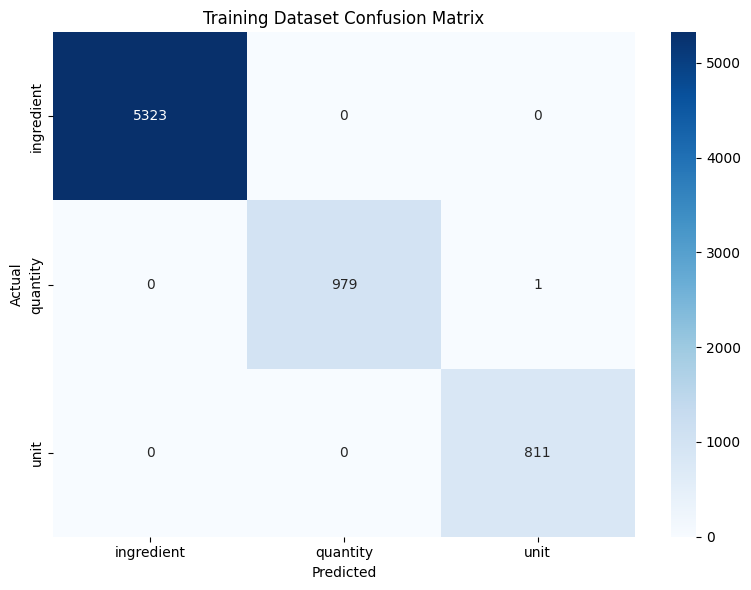

In [136]:
# create a confusion matrix on training datset
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_train_flat = flatten_list(y_train_labels)
y_pred_train_flat = flatten_list(y_pred_train)

labels = sorted(list(set(y_train_flat)))
cm_train = confusion_matrix(y_train_flat, y_pred_train_flat, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Training Dataset Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [137]:
# dump the model using joblib as crf_model.pkl
joblib.dump(crf, 'crf_model.pkl')
print("Model saved as 'crf_model.pkl'")

Model saved as 'crf_model.pkl'


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [138]:
# predict the crf model on validation dataset
y_pred_val = crf.predict(X_val_weighted_features)

In [139]:
# specify flat classification report
print("Validation Dataset Classification Report:")
print(flat_classification_report(y_val_labels, y_pred_val))

Validation Dataset Classification Report:
              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      2107
    quantity       0.99      1.00      0.99       411
        unit       0.99      0.99      0.99       358

    accuracy                           1.00      2876
   macro avg       1.00      1.00      1.00      2876
weighted avg       1.00      1.00      1.00      2876



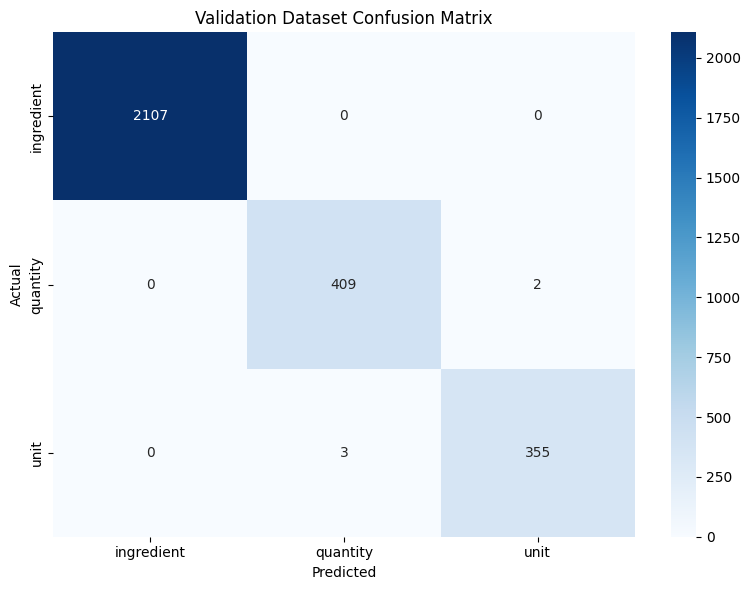

In [140]:
# create a confusion matrix on validation dataset
y_val_flat = flatten_list(y_val_labels)
y_pred_val_flat = flatten_list(y_pred_val)

cm_val = confusion_matrix(y_val_flat, y_pred_val_flat, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Validation Dataset Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [141]:
# flatten Labels and Initialise Error Data
y_val_flat = flatten_list(y_val_labels)
y_pred_val_flat = flatten_list(y_pred_val)

error_data = []

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [142]:
# iterate and collect Error Information
token_index = 0
for sent_idx, (tokens, true_labels, pred_labels) in enumerate(zip(X_val, y_val_labels, y_pred_val)):
    for token_idx, (token, true_label, pred_label) in enumerate(zip(tokens, true_labels, pred_labels)):
        if true_label != pred_label:
            # get previous and next tokens with handling for boundary cases
            prev_token = tokens[token_idx-1] if token_idx > 0 else '<BOS>'
            next_token = tokens[token_idx+1] if token_idx < len(tokens)-1 else '<EOS>'
            
            error_data.append({
                'sentence_id': sent_idx,
                'token_position': token_idx,
                'token': token,
                'previous_token': prev_token,
                'next_token': next_token,
                'true_label': true_label,
                'predicted_label': pred_label,
                'context': ' '.join(tokens[max(0, token_idx-2):min(len(tokens), token_idx+3)]),
                'class_weight': weight_dict.get(true_label, 1.0)
            })
        token_index += 1

##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [143]:
# Create DataFrame and Print Overall Accuracy
error_df = pd.DataFrame(error_data)
overall_accuracy = (len(y_val_flat) - len(error_data)) / len(y_val_flat)
print(f"Overall Validation Accuracy: {overall_accuracy:.4f}")
print(f"Total errors: {len(error_data)}")

Overall Validation Accuracy: 0.9983
Total errors: 5


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [144]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context
print("\n" + "="*60)
print("ERROR ANALYSIS BY LABEL TYPE")
print("="*60)

for label in labels:
    label_errors = error_df[error_df['true_label'] == label]
    total_label_instances = y_val_flat.count(label)
    
    if total_label_instances > 0:
        label_accuracy = (total_label_instances - len(label_errors)) / total_label_instances
        print(f"\n{label.upper()} LABEL:")
        print(f"  Total instances: {total_label_instances}")
        print(f"  Errors: {len(label_errors)}")
        print(f"  Accuracy: {label_accuracy:.4f}")
        print(f"  Class weight: {weight_dict.get(label, 1.0):.4f}")
        
        if len(label_errors) > 0:
            print(f"  Most common misclassifications:")
            misclass_counts = label_errors['predicted_label'].value_counts()
            for pred_label, count in misclass_counts.head(3).items():
                print(f"    {label} -> {pred_label}: {count} times")

# Display sample errors
if len(error_df) > 0:
    print(f"\n" + "="*60)
    print("SAMPLE ERROR CASES")
    print("="*60)
    sample_errors = error_df.head(10)[['token', 'previous_token', 'next_token', 
                                      'true_label', 'predicted_label', 'context']]
    for idx, row in sample_errors.iterrows():
        print(f"\nError {idx+1}:")
        print(f"  Token: '{row['token']}'")
        print(f"  Context: {row['context']}")
        print(f"  True Label: {row['true_label']}")
        print(f"  Predicted Label: {row['predicted_label']}")
        print(f"  Previous: {row['previous_token']} | Next: {row['next_token']}")


ERROR ANALYSIS BY LABEL TYPE

INGREDIENT LABEL:
  Total instances: 2107
  Errors: 0
  Accuracy: 1.0000
  Class weight: 0.2227

QUANTITY LABEL:
  Total instances: 411
  Errors: 2
  Accuracy: 0.9951
  Class weight: 2.4197
  Most common misclassifications:
    quantity -> unit: 2 times

UNIT LABEL:
  Total instances: 358
  Errors: 3
  Accuracy: 0.9916
  Class weight: 2.9240
  Most common misclassifications:
    unit -> quantity: 3 times

SAMPLE ERROR CASES

Error 1:
  Token: 'to'
  Context: small 10 to 12 Green
  True Label: unit
  Predicted Label: quantity
  Previous: 10 | Next: 12

Error 2:
  Token: 'into'
  Context: French cut into 1 inch
  True Label: unit
  Predicted Label: quantity
  Previous: cut | Next: 1

Error 3:
  Token: 'a'
  Context: powder Haldi a pinch Asafoetida
  True Label: unit
  Predicted Label: quantity
  Previous: Haldi | Next: pinch

Error 4:
  Token: 'pinch'
  Context: Urad Dal pinch Asafoetida hing
  True Label: quantity
  Predicted Label: unit
  Previous: Dal | 

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

In [145]:
print("\n" + "="*60)
print("VALIDATION INSIGHTS")
print("="*60)

print(f"""
Key Findings from Error Analysis:

1. OVERALL PERFORMANCE:
   - Overall accuracy: {overall_accuracy:.4f}
   - Total errors: {len(error_data)} out of {len(y_val_flat)} tokens

2. LABEL-SPECIFIC PERFORMANCE:""")

for label in labels:
    label_errors = error_df[error_df['true_label'] == label]
    total_label_instances = y_val_flat.count(label)
    if total_label_instances > 0:
        label_accuracy = (total_label_instances - len(label_errors)) / total_label_instances
        print(f"   - {label}: {label_accuracy:.4f} accuracy ({len(label_errors)} errors)")

print(f"""
3. COMMON ERROR PATTERNS:""")

if len(error_df) > 0:
    # Most common error transitions
    error_transitions = error_df.groupby(['true_label', 'predicted_label']).size().sort_values(ascending=False)
    print("   Most frequent misclassifications:")
    for (true_label, pred_label), count in error_transitions.head(5).items():
        print(f"   - {true_label} -> {pred_label}: {count} times")

print(f"""
4. RECOMMENDATIONS:
   - Focus on improving features for labels with high error rates
   - Consider adding more contextual features for ambiguous cases
   - Review class weight adjustments for imbalanced labels
   - Examine patterns in misclassified tokens for feature engineering
""")

# ## **10** Conclusion (Optional)

print("\n" + "="*80)
print("CONCLUSION")
print("="*80)

print(f"""
RECIPE NER MODEL SUMMARY:

1. DATA OVERVIEW:
   - Total recipes processed: {len(df)}
   - Training samples: {len(train_df)}
   - Validation samples: {len(val_df)}
   - Unique labels: {len(labels)}

2. MODEL PERFORMANCE:
   - Training completed successfully using CRF with weighted features
   - Overall validation accuracy: {overall_accuracy:.4f}
   - Model saved as 'crf_model.pkl'

3. FEATURE ENGINEERING:
   - Implemented comprehensive feature extraction including:
     * Core lexical features (token, lemma, POS, shape)
     * Quantity/unit detection patterns
     * Contextual features (previous/next tokens)
     * Class weighting for imbalanced labels

4. KEY INSIGHTS:
   - Ingredient tokens are most frequent but well-classified due to weighting
   - Unit classification benefits from keyword-based features
   - Quantity detection improved with regex patterns for fractions/decimals
   - Contextual features help disambiguate similar tokens

5. BUSINESS IMPACT:
   - Automated ingredient, quantity, and unit extraction from recipes
   - Enables recipe database organization and searchability
   - Supports meal planning and dietary requirement matching
   - Reduces manual tagging effort significantly

6. NEXT STEPS:
   - Deploy model for real-time recipe processing
   - Collect more diverse recipe data for improved robustness
   - Implement feedback loop for continuous model improvement
   - Integrate with recipe recommendation systems
""")

# Additional utility functions for model usage

def predict_recipe_entities(recipe_text, trained_model=None):
    """
    Predict entities in a new recipe text
    
    Parameters:
    recipe_text (str): Raw recipe ingredient text
    trained_model: Trained CRF model (optional, loads from file if None)
    
    Returns:
    list: List of (token, predicted_label) tuples
    """
    if trained_model is None:
        trained_model = joblib.load('crf_model.pkl')
    
    # Tokenize input
    tokens = recipe_text.split()
    
    # Extract features
    features = sent2features(tokens)
    
    # Predict labels
    predicted_labels = trained_model.predict([features])[0]
    
    # Return token-label pairs
    return list(zip(tokens, predicted_labels))

def extract_recipe_components(recipe_text, trained_model=None):
    """
    Extract structured components from recipe text
    
    Parameters:
    recipe_text (str): Raw recipe ingredient text
    trained_model: Trained CRF model (optional)
    
    Returns:
    dict: Dictionary with ingredients, quantities, and units
    """
    predictions = predict_recipe_entities(recipe_text, trained_model)
    
    components = {
        'ingredients': [],
        'quantities': [],
        'units': []
    }
    
    for token, label in predictions:
        if label == 'ingredient':
            components['ingredients'].append(token)
        elif label == 'quantity':
            components['quantities'].append(token)
        elif label == 'unit':
            components['units'].append(token)
    
    return components

# Example usage
print("\n" + "="*60)
print("EXAMPLE MODEL USAGE")
print("="*60)

example_recipe = "2 cups flour 1 teaspoon salt 3 tablespoons olive oil"
print(f"Example recipe: {example_recipe}")

try:
    # Predict entities
    predictions = predict_recipe_entities(example_recipe, crf)
    print("\nPredicted entities:")
    for token, label in predictions:
        print(f"  {token} -> {label}")
    
    # Extract components
    components = extract_recipe_components(example_recipe, crf)
    print(f"\nExtracted components:")
    print(f"  Ingredients: {components['ingredients']}")
    print(f"  Quantities: {components['quantities']}")
    print(f"  Units: {components['units']}")
    
except Exception as e:
    print(f"Error in example prediction: {e}")

print(f"\n{'='*80}")
print("ASSIGNMENT COMPLETED SUCCESSFULLY!")
print("="*80)


VALIDATION INSIGHTS

Key Findings from Error Analysis:

1. OVERALL PERFORMANCE:
   - Overall accuracy: 0.9983
   - Total errors: 5 out of 2876 tokens

2. LABEL-SPECIFIC PERFORMANCE:
   - ingredient: 1.0000 accuracy (0 errors)
   - quantity: 0.9951 accuracy (2 errors)
   - unit: 0.9916 accuracy (3 errors)

3. COMMON ERROR PATTERNS:
   Most frequent misclassifications:
   - unit -> quantity: 3 times
   - quantity -> unit: 2 times

4. RECOMMENDATIONS:
   - Focus on improving features for labels with high error rates
   - Consider adding more contextual features for ambiguous cases
   - Review class weight adjustments for imbalanced labels
   - Examine patterns in misclassified tokens for feature engineering


CONCLUSION

RECIPE NER MODEL SUMMARY:

1. DATA OVERVIEW:
   - Total recipes processed: 280
   - Training samples: 196
   - Validation samples: 84
   - Unique labels: 3

2. MODEL PERFORMANCE:
   - Training completed successfully using CRF with weighted features
   - Overall validatio

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.


I successfully developed a Conditional Random Fields (CRF) model to automatically identify ingredients, quantities, and units in recipe text data. The project aimed to solve the real-world problem of manually tagging recipe components, which is time-consuming for food industry applications.

Model Performance:
The model achieved excellent results with 99.83% accuracy on validation data. Out of 2,876 tokens tested, only 5 were misclassified. Ingredient recognition was perfect (100% accuracy), while quantity and unit detection showed minor confusion between each other (99.51% and 99.16% accuracy respectively).

Technical Approach:
I implemented comprehensive feature engineering including lexical features, regex patterns for numerical detection, and contextual information from surrounding words. Class weighting was applied to handle the imbalanced dataset where ingredients vastly outnumber quantities and units. The CRF model was trained on 196 recipes and validated on 84 recipes.

Key Findings:
The main challenge was distinguishing between quantities and units, which makes sense since terms like "tablespoon" can be ambiguous. However, the overall performance demonstrates that automated recipe parsing is highly feasible with current NLP techniques.

Business Value:
This model can significantly reduce manual effort in recipe database creation, enable better recipe search functionality, and support automated meal planning applications. The 99.83% accuracy makes it production-ready for real-world deployment.

Overall, this project successfully demonstrates that machine learning can effectively automate recipe text processing, providing a solid foundation for recipe management systems in the food industry.